---
---
# Introducción. Monitorización
Una vez hemos estudiado los principales problemas de aprendizaje supervisado existentes y sus algoritmos correspondientes, es hora de plantearse la cuestión de cómo podemos asignar de forma inteligente los valores óptimos de los parámetros de un modelo, para que se adapten de la mejor forma posible a nuestros datos. Para ello, veremos en primer lugar cómo podemos estudiar con un *dataset* la eficacia de nuestro modelo en distintos entornos.

Este apartado exige al usuario un cierto conocimiento de los parámetros que dicho modelo posee, para que ellos puedan ser consecuentemente modificados con coherencia. Además, la alta cantidad de experimentos que se llevan a cabo exigen de procedimientos más estructurados para registrar, validar y comparar los resultados de los mismos, los cuales los obtenemos mediante las herramientas de **monitorización**. 

Una parte vital para el análisis del rendimiento de nuestros modelos es ser capaces de obtener información detallada en tiempo real de las cantidades que deseemos, como por ejemplo pueden ser:

* Funciones de pérdida.
* Métricas asociadas a nuestro problema.
* Valores de los pesos asociados a nuestros parámetros.

Herramientas como [*Weights and Biases*](https://wandb.ai/home) nos proponen una efectiva solución. Dependiendo de la implementación que usemos (scikit-learn, TensorFlow, PyTorch,...), esta plataforma posee distintas formas de integración; nosotros optaremos para integrar en nuestro ejemplo por la más *manual*, que coincide con la que se emplea en PyTorch, dado que en ambas tenemos que escribir el bucle de entrenamiento a mano (aunque PyTorch tiene muchas funcionalidades extra, como el cálculo automático de gradientes).

Además, esta opción está posicionada entre las más populares del momento y es la que mayor tasa de incremento de uso posee. En ella, seremos capaces de hacer todo lo que aparece arriba indicado, además de muchas otras cosas como [añadir visualizaciones asociadas a la validación de experimentos](https://wandb.ai/azm630/GenImgModels_VAE?workspace=user-azm630) ó [crear reportes](https://wandb.ai/azm630/Intent_Classifier_NLU/reports/NLU-training-report--VmlldzoyMDY2MzU0).

Iremos a continuación sobre un ejemplo que describe la metodología a seguir.

---
---
# Optimización: Caso práctico

---
## Credenciales *Weights and Biases*

En primer lugar, debemos darnos de alta en dicha página y generar una API key en la sección *Settings-->Danger Zone-->API Keys-->New key*. Tras este paso, introducimos como variables de entorno nuestros credenciales:


In [1]:
import os
os.environ['WANDB_API_KEY'] = '1bb44e6be47564584868ec55bac8cf468cf0e47f'
os.environ['WANDB_USERNAME'] = 'azm630'

---
## Datos
Comenzamos generando un *dataset* popular de clasificación, consistente en la distinción de tres tipos de vinos basados en determinadas propiedades químicas:

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
#Importamos datos
X= load_wine().data 
y = load_wine().target
#Obtenemos los datos en forma de DataFrame para visualizar las columnas con sus valores
data = pd.concat([pd.DataFrame(load_wine().data, columns = load_wine().feature_names),pd.DataFrame(load_wine().target, columns = ['label'])], axis = 1)

Aquí podemos observar la información relativa a sus variables:

In [3]:
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,label
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


Echamos un vistazo rápido a la distribución general de los datos, aunque el objetivo en este apartado no es hacer un EDA extenso

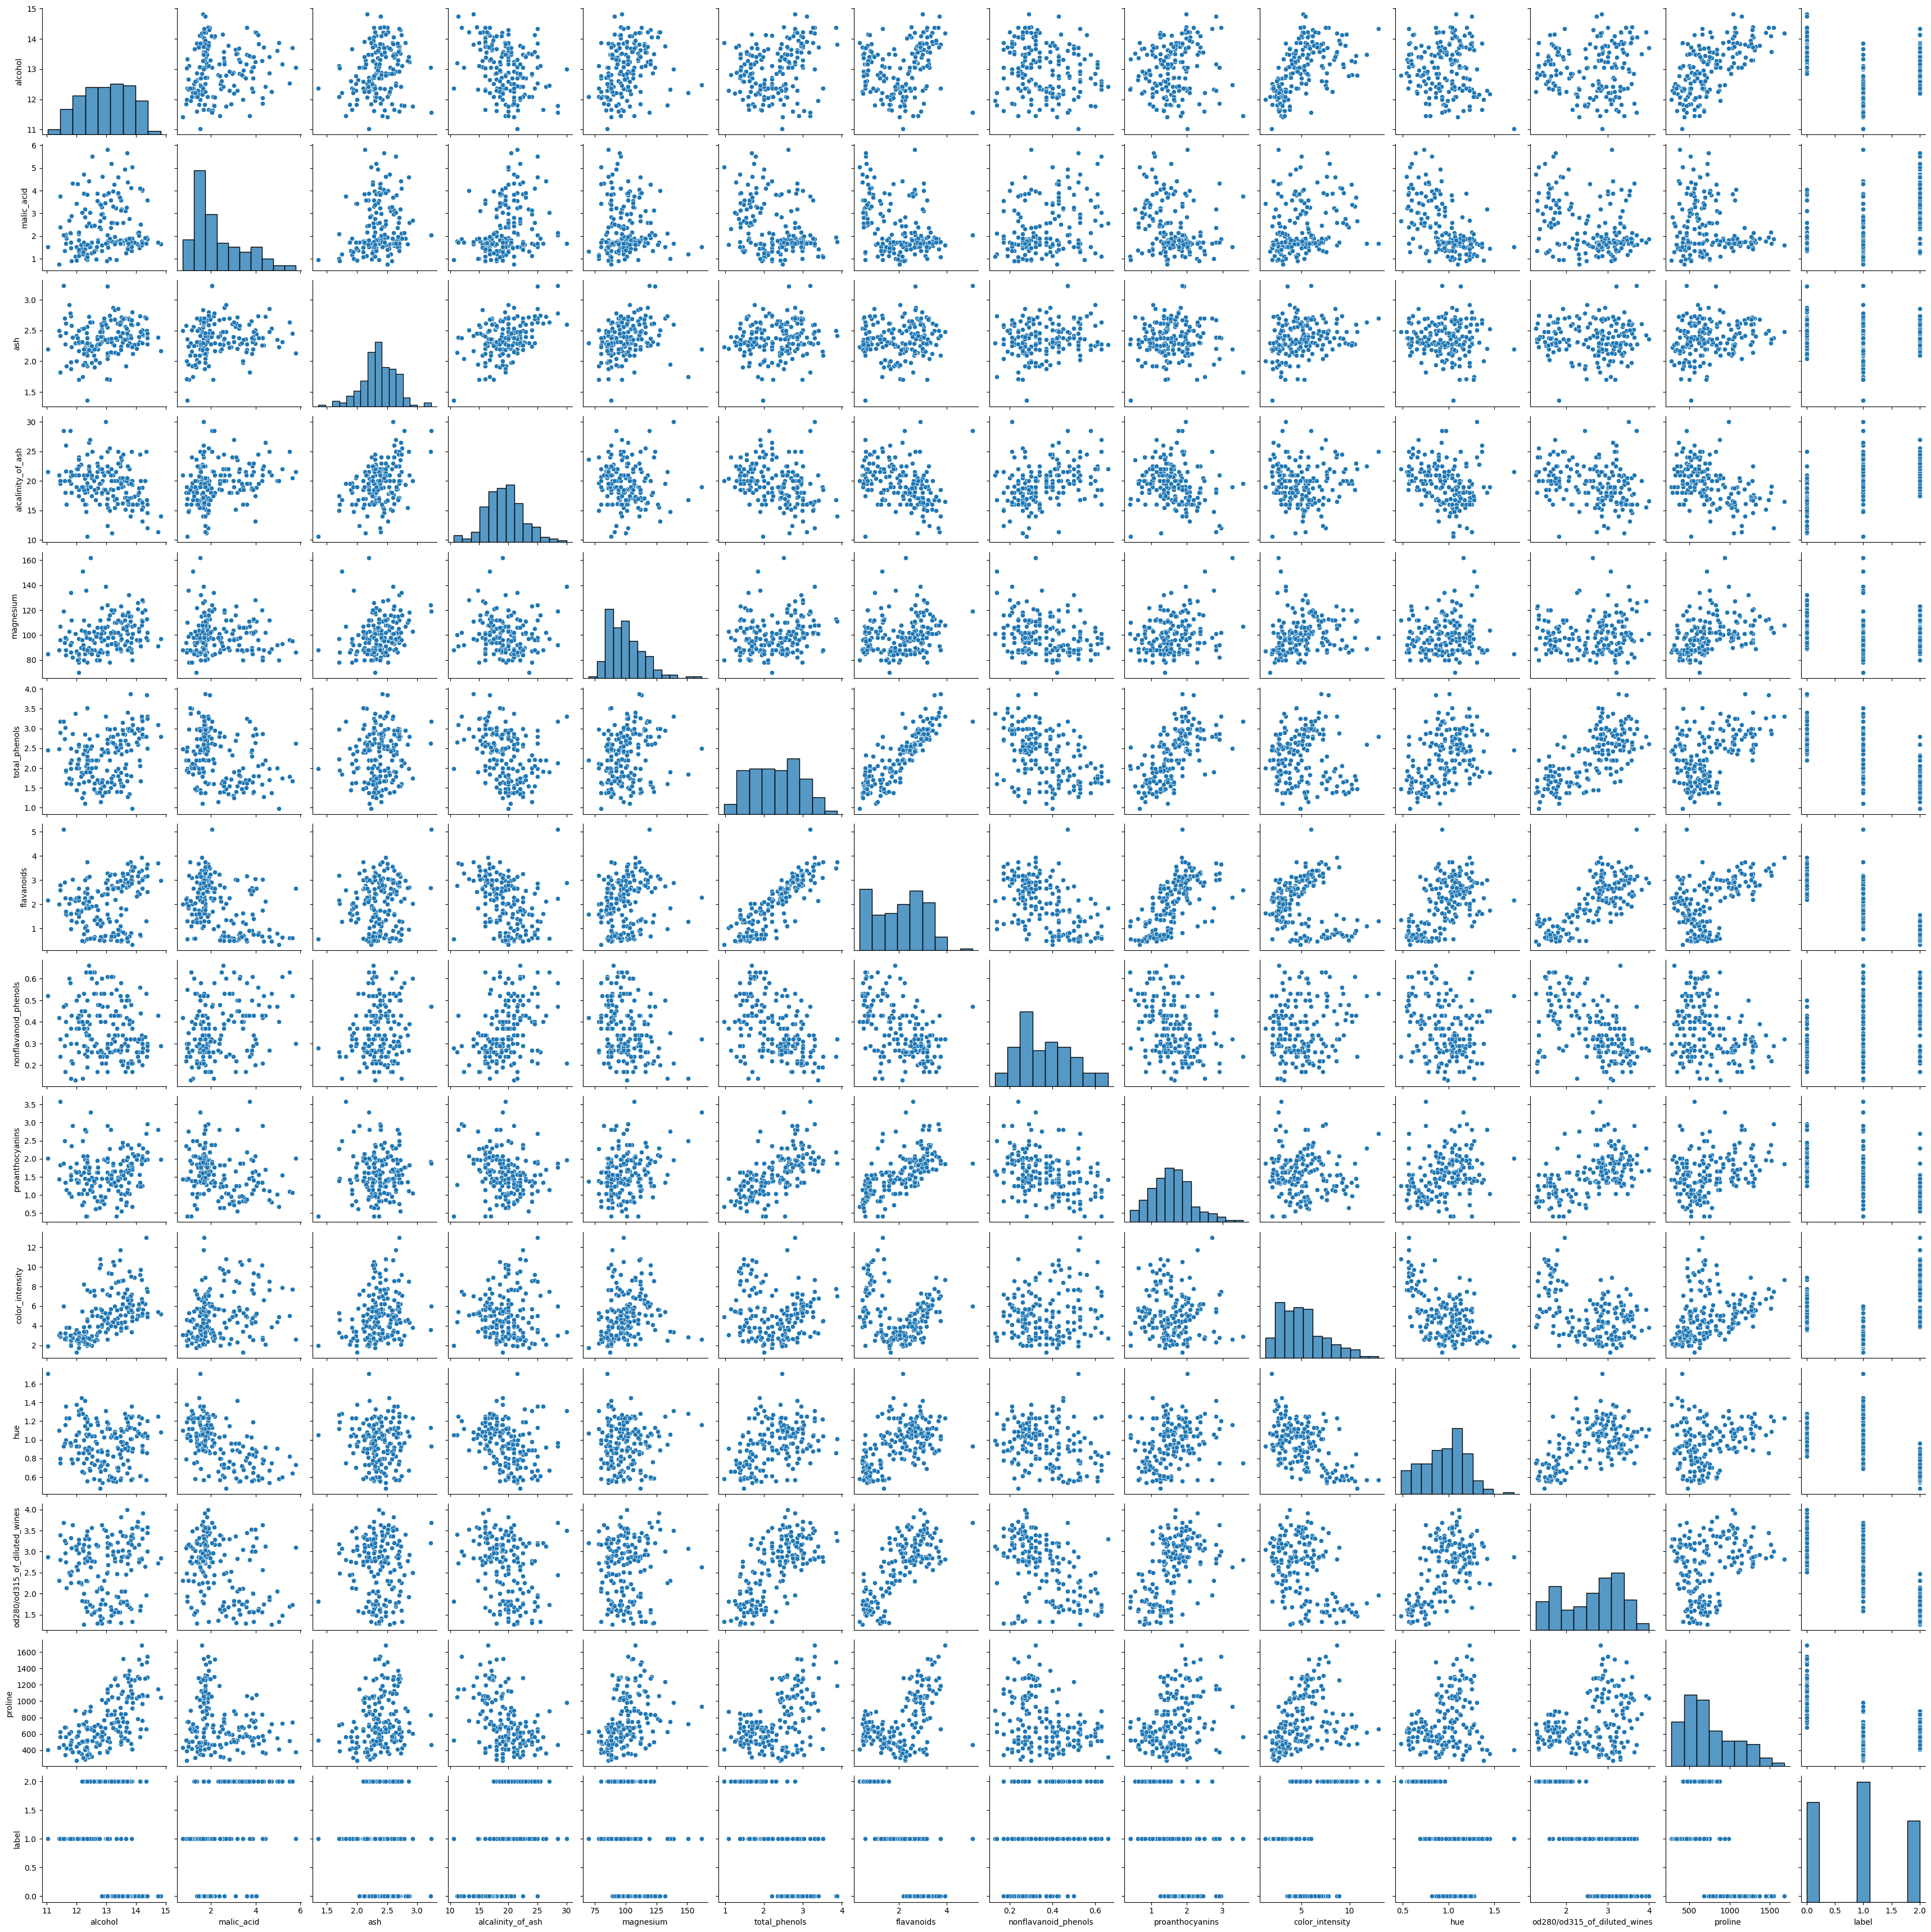

In [4]:
import seaborn as sns
sns.pairplot(data)

Vemos en particular que la distribución de datos en la variable respuesta es ligeramente asimétrica, aunque no lo suficiente como para plantearnos intervenir.

Finalmente, escalamos las variables de entrada al modelo:

In [5]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

---
## Modelo
Instanciamos a continuación un modelo de los estudiados, que será *Random Forest*. Damos total libertad al usuario de realizar los siguientes pasos con cualquier otro algoritmo.

In [6]:
from sklearn.ensemble import RandomForestClassifier

A continuación, estudiamos qué parámetros tiene dicho modelo, qué representan y cómo podemos modificarlos de manera razonable. En estos casos, es muy frecuente recurrir a la documentación, bien en [formato online](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) o con el siguiente comando:

In [ ]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters


---
## Análisis de eficacia del modelo
En este apartado, veremos cómo mediante unos datos limitados podemos estudiar lo resistente que es nuestro modelo a datos que no conoce. Esta técnica se basa en avanzar un paso más en la idea de dividir los datos en el segmento de entrenamiento y validación, conocida como **K-Fold**.

En el primer enfoque que estudiamos, se dividían los datos según un *ratio* en datos para entrenar al modelo, y datos de validación, típicamente del orden 80-20 o 70-30. En este caso, tomamos los datos y los dividimos en un número igual de componentes, *k*, de tal modo que en cada iteración uno de ellos sea los datos de validación, y el aglomerado del resto los datos de entrenamiento:

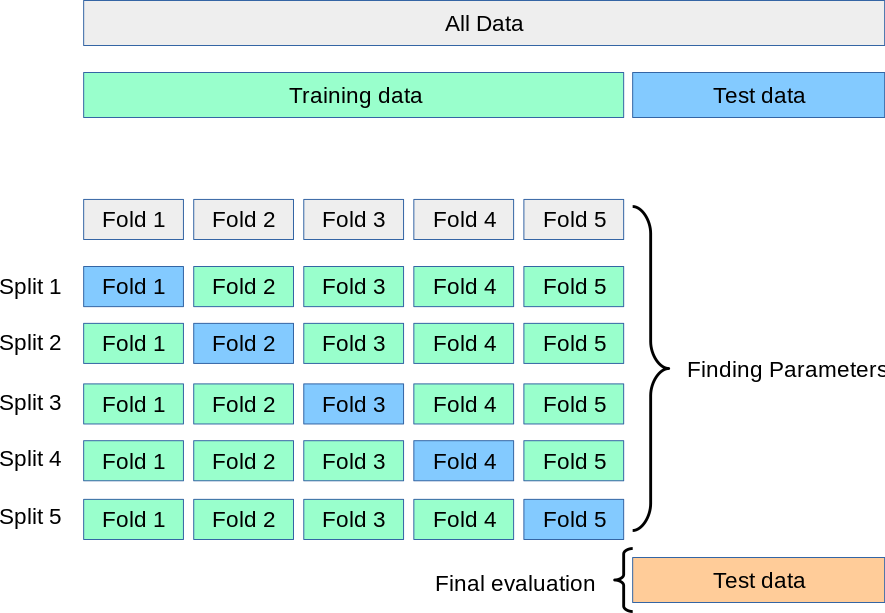

De esta forma, tendremos tantas iteraciones como valor hayamos asignado a *k*, y en cada paso evaluamos el error cometido por el modelo para, finalmente, agregar todos los errores en forma de media.

Existen una serie de variantes que pasamos a detallar:

*   Train/Test Split: El ejemplo más elemental, que ya habíamos discutido en secciones previas.
*   LOOCV: Llevado al extremo completamente opuesto, si tomamos *k* como el número de elementos de nuestro *dataset*, tendremos tantas iteraciones como tamaño tenga nuestro dataset.
*   Stratified: A la hora de hacer la división de los datos, es conveniente garantizar que en cada subdivisión haya un número proporcional de datos en cada clase (o distribución en el caso de regresión) proporcional a la de los datos de entrada. Esto se conoce como *stratified cross-validation*.
*   Repeated: También podemos repetir la técnica de división de datos *k*-Fold *n* veces, de modo que en cada repetición se mezclen los datos para dar lugar a nuevas combinaciones de *train/test datasets*.
*   Nested: Cuando realizamos un proceso *k*-Fold dentro de cada división de otro *k*-Fold.


Las más frecuentes en virtud de sus buenos resultados, y que por tanto usaremos, son la tercera y particularmente la cuarta opción.

Veamos en primer lugar cómo implementar un método de *K-Fold* manualmente, procediendo después a recurrir a conocidas librerías:

In [7]:
from sklearn.base import clone

In [8]:
def Repeated_K_Fold(X, y, model, k = 5, rep = 2):
  '''Para un cierto dataset dividido en features (X : np.array) y label (y : np.array), realizamos la técnica K-Fold con repetición'''
  data = np.concatenate((X, y), axis = 1)
  idx = np.arange(data.shape[0])
  results = np.array([])
  for iter in range(rep):
    np.random.shuffle(idx)
    list_idx = np.array_split(idx, k)
    #Loop K-Fold
    for test_idx in list_idx:
      model_cloned = clone(model)
      X_train, X_test, y_train, y_test = data[~test_idx,:-1], data[test_idx,:-1], data[~test_idx,-1], data[test_idx,-1]
      model_cloned.fit(X_train, y_train)
      results = np.append(results, model_cloned.score(X_test, y_test))
  print('La accuracy media global es de {avg:.2f}±{std:.3f}'.format(avg = np.mean(results), std = np.std(results)))

In [9]:
Repeated_K_Fold(X, y.reshape(-1,1), RandomForestClassifier())

La accuracy media global es de 0.97±0.034


Procedemos ahora a hacer uso de librerías para acometer este problema:

In [10]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
results = np.array([])
for train_index, test_index in skf.split(X, y):
  model_cloned = clone(RandomForestClassifier())
  model_cloned.fit(X[train_index,:], y[train_index])
  results = np.append(results, model_cloned.score(X[test_index,:], y[test_index]))
print('La accuracy media global es de {avg:.2f}±{std:.3f}'.format(avg = np.mean(results), std = np.std(results)))

La accuracy media global es de 0.97±0.025


---
## Random Search
Vemos que aparece junto con cada parámetro, un valor por defecto y además el tipo de dato junto con una explicación del mismo. Pasamos a escribir en un diccionario el valor de los parámetros y un **espacio de parámetros** en el cual podamos seleccionar aleatoriamente.

A fin de mostrar variedad de modelos, emplearemos en este caso *Supporting Vector Machine*:

In [ ]:
#Librerías
from sklearn import svm
#Consultamos parámetros
help(svm.SVC())

Help on SVC in module sklearn.svm._classes object:

class SVC(sklearn.svm._base.BaseSVC)
 |  SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`sklearn.svm.LinearSVC` or
 |  :class:`sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  ot

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
#Instanciamos el modelo con los parámetros por defecto
SVC = svm.SVC()
#Definimos una estrategia K-Fold estratificada para evaluar dichos parámetros
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#Creamos un diccionario con los posibles valores de los parámetros que queramos validar
space = {'C': np.arange(0.01,1,0.01),
         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
         'degree': np.arange(2,8)
         }
#Iniciamos la búsqueda
search = RandomizedSearchCV(SVC, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
#Entrenamos
resultRS = search.fit(X, y)
#Recogemos los resultados
print('Best Score: %s' % resultRS.best_score_)
print('Best Hyperparameters: %s' % resultRS.best_params_)

Best Score: 0.9569312169312169
Best Hyperparameters: {'kernel': 'linear', 'degree': 5, 'C': 0.17}


Como resultado de la búsqueda aleatoria, obtenemos un modelo con una *accuracy* alta y los parámetros detallados.

---
## Grid Search
Una vez tenemos una intuición de en qué tipo de configuración de parámetros puede localizarse la optimalidad, efectuamos una búsqueda más exhaustiva en una región más concreta del espacio previamente definido, creando una malla sobre la que validemos cada punto de la misma:

In [ ]:
from sklearn.model_selection import GridSearchCV
#Instanciamos el modelo con los parámetros por defecto
SVC = svm.SVC()
#Definimos una estrategia K-Fold estratificada para evaluar dichos parámetros
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#Creamos un diccionario con los posibles valores de los parámetros que queramos validar, a partir de lo obtenido previamente
space = {'C': np.arange(resultRS.best_params_['C']*.5,resultRS.best_params_['C']*1.5,0.01),
         'kernel': ['linear', 'poly'],
         'degree': np.arange(resultRS.best_params_['degree']-2,resultRS.best_params_['degree']+2)
         }
#Iniciamos la búsqueda en TODOS los posibles casos
search = GridSearchCV(SVC, space, scoring='accuracy', n_jobs=-1, cv=cv)
#Entrenamos
resultGS = search.fit(X, y)
#Recogemos los resultados
print('Best Score: %s' % resultGS.best_score_)
print('Best Hyperparameters: %s' % resultGS.best_params_)

Best Score: 0.9626455026455026
Best Hyperparameters: {'C': 0.085, 'degree': 3, 'kernel': 'linear'}


Vemos que, en efecto, hemos conseguido mejorar aún más los resultados del modelo previamente obtenido, y podemos tomar tal configuración de datos como la óptima para nuestro problema concreto.

---
## Bayesian Optimisation



### Introducción

Los métodos vistos hasta ahora se conocen como **deterministas**, pues no importa el valor obtenido en cada iteración para proceder con el siguiente de una lista de valores previamente proporcionados. En el caso que nos ocupa, sí condicionaremos el resultado de nuestra siguiente elección de bloque de hiperparámetros en base a lo obtenido previamente, siempre partiendo de un conjunto de valores que puedan tomar.

Para entender completamente el funcionamiento de este proceso, tenemos que dar un enfoque más *matemático* al problema: supongamos que el abanico de valores posibles de hiperparámetros lo podemos contener en un conjunto $\mathcal{X}$ (que puede ser el factor de aprendizaje, *momentum*, profundidad de los árboles de decisión,...), y que disponemos de una cierta función de pérdida $L_{\mathcal{x}}(\mathbf{\theta})$ (que puede ser la entropía, error cuadrático medio,...). Nuestro objetivo consiste pues en **minimizar la función de pérdida encontrando el argumento adecuado de hiperparámetros**; esto es, queremos encontrar:

$$x^*=\min_{\mathcal{x}\in\mathcal{X}}{L_{\mathcal{x}}(\theta)}$$

Naturalmente que este problema de optimización no es sencillo en general, pero sí podemos usar el enfoque bayesiano para, de forma recurrente, construir un modelado probabilístico y dar lugar a lo que se conoce [en la literatura](https://static.sigopt.com/b/20a144d208ef255d3b981ce419667ec25d8412e2/static/pdf/SigOpt_Bayesian_Optimization_Primer.pdf) como una **función subrogada**, $P(y|\mathcal{x})$, donde $y$ es el valor obtenido en la función de pérdida para la elección de hiperparámetros $\mathcal{x}$. Para más información sobre técnicas de cómo emplear esta función subrogada en la elección de un nuevo conjunto de hiperparámetros, puede consultar [esta referencia](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf).

### Implementación

Veamos ahora cómo poner estas nociones en práctica de forma automática con *Weights and Biases*. El objeto de la misma que nos permite agrupar todas nuestras ejecuciones y realizar los cálculos pertinentes se conoce como [sweep](https://docs.wandb.ai/guides/sweeps). Para emplearlo y configurarlo convenientemente, vayamos paso a paso:

* Primero, importamos las librerías que vayamos a usar:

In [12]:
import numpy as np
import pandas as pd
import os
import json
import logging as log
from typing import Dict, List
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import wandb
import sys
from pathlib import Path

* Seguidamente, cargamos y preprocesamos los datos a emplear:

In [14]:
df = pd.read_csv('https://raw.githubusercontent.com/jeffheaton/aifh/master/vol1/python-examples/datasets/breast-cancer-wisconsin.csv')
df.drop('id', axis=1, inplace=True)
df = df.replace("?",np.nan).dropna()
df['bare_nucleoli'] = pd.to_numeric(df['bare_nucleoli'], errors='raise')
df.loc[df['class']==2,'class'] = 0
df.loc[df['class']==4,'class'] = 1
df.to_csv('breast-cancer-winsconsin.csv')

* Escribimos ahora un par de métodos auxiliares que nos ayudarán a estructurar el código:

In [26]:
# Método para obtener la entropía como función de pérdida,
# y el f1-score ponderado como métrica 
def compute_metrics(inputs:List[np.array], targets:List[np.array]):
    # Formateamos salida de modelo
    y_true = np.concatenate(targets)
    y_pred_proba = np.concatenate(inputs, axis=0)
    y_pred_logproba = np.log(y_pred_proba+1e-5)
    y_pred = np.argmax(y_pred_proba, axis=-1)
    y_pred_onehot = np.zeros(shape=(y_pred.size, y_pred.max() + 1))
    y_pred_onehot[np.arange(y_pred.size), y_pred] = 1
    # f1 score
    f1 = f1_score(y_true, y_pred, average = 'weighted')
    # Entropía
    catcross = -np.mean((y_pred_logproba[:,None,:] @ y_pred_onehot[:,:,None]).squeeze())
    return {'oof_f1_weighted':f1, 'oof_catcross':catcross}

# Método para especificar hiperparámetros y sesión, que
# retorna un ID de sweep
def get_sweep_id(sweep_config_path, project_id):
    with open(sweep_config_path, 'r') as f:
        sweep_config = json.load(f)
    sweep_id = wandb.sweep(sweep_config, project=project_id)
    return sweep_id

# Método que empleará el sweep de Weights and Biases, que debe
# retornar las métricas que queramos optimizar/tener en cuenta.
# Dentro del mismo, debe estar el entrenamiento del modelo a 
# nuestro gusto; en este caso, hacemos 5-fold estratificado con
# un clasificador Random Forest.
def fitter_fn(df:pd.DataFrame=df, target_var:str='class', n_splits:int=5, config:Dict=None, random_state:int=123):
    # Iniciar una nueva sesión en Weights and Biases
    with wandb.init(config=config):
        # La variable "config" almacena inputs y parámetros
        config = wandb.config
        # Objeto que estratifica los datos de forma balanceada
        skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
        inputs = []
        targets = []
        for train_idx, test_idx in skf.split(df.drop(target_var, axis=1).values, df[target_var].values):
            # Obtenemos los datos de cada partición
            X_train, y_train = df.loc[train_idx, ~df.columns.isin([target_var])].values, df.loc[train_idx, target_var].values
            X_test, target = df.loc[test_idx, ~df.columns.isin([target_var])].values, df.loc[test_idx, target_var].values
            # Definimos el modelo
            model = RandomForestClassifier(
                n_estimators = config.n_estimators,
                criterion = config.criterion
                )
            # Entrenamos el modelo
            model.fit(X_train, y_train)
            # Calculamos las predicciones
            input = model.predict_proba(X_test)
            # Almacenamos las predicciones
            inputs.append(input)
            targets.append(target)
        # Calculamos entropía del análisis out-of-folder
        metrics_dct = compute_metrics(inputs, targets)
        wandb.log(metrics_dct)

* Finalmente, en estas simples líneas podemos ejecutar todo:

In [ ]:
# Logs
root = log.getLogger()
root.setLevel(log.DEBUG)
handler = log.StreamHandler(sys.stdout)
handler.setLevel(log.DEBUG)
formatter = log.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

# Variables
input_path='breast-cancer-winsconsin.csv'
target_var='class'
bayesian_iter=20
wandb_config_path='wandb_config.json'
sweep_config_path='sweep_config.json'

# Configuración Weights and Biases
with open(wandb_config_path) as f:
    wandb_dct = json.load(f)
    os.environ['WB_KEY'] = wandb_dct['WANDB_API_KEY']
# Weights and Biases session
wandb.login(key=wandb_dct['WANDB_API_KEY'])
# Read data
df = pd.read_csv(input_path, index_col=[0]).reset_index(drop=True)
# Create a sweep for *bayesian* searchk
sweep_id = get_sweep_id(sweep_config_path, wandb_dct['WANDB_PROJECT'])
# Run the sweep
wandb.agent(sweep_id, function=fitter_fn, count=bayesian_iter)